### Healthcare Analytics 
##### (To utilise machine learning strategies to predict length of patient stay to improve efficiency of healthcare managment in a  hospital )

### Built an end-to-end machine learning pipeline using object oriented programming methods(data ingestion to evaluation metric selection)

#### Pipeline stages: 
#####     1. Data injestion and EDA
#####     2. Identify different target classes
#####     3. Categorize data into numerical/categorical
#####     4. Missing value imputation
#####     5. Outlier removal 
#####     6. Categorical transformation using WOE
#####     7. Feature selection using RFE
#####     8. Model building (Logistic, Decision tree, Random forest, Gradient Boosting Method) using GridSearch
#####     9. Evaluation metrics(Accuracy, Precision, recall, confusion matrix, ROC-AUC curve, Precision-Recall curve, Cohen-Kappa)
    

##### The pipeline can be used for all multiclass classification problems - I have taken a use-case of fetal health classification later to demonstrate the process

In [5]:
import pandas as pd
from numpy import array
import numpy as np
import json
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.preprocessing import LabelEncoder as LB
from category_encoders import WOEEncoder as WOE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV as rfe
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss, balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve as sk_precision_recall_curve
import os

In [6]:
class unique_value_list:
    def __init__(self,col):
        self.mylist = []
        self.col = col
        self.target_list = []
        self.target_classes = None
        self.idx2class = {} 
        self.class2idx = {}
    def targetOHE_column_list(self,df):
        self.target_classes = df.loc[:,self.col].nunique()
        for col in range(self.target_classes):
            self.target_list.append(str('target') + str(col))
        return self.target_list
    def convert_unique_label(self,df):
    #create a mapping from labels to a unique integer and vice versa for labelling and prediction later
        self.mylist = df[self.col].unique()
        self.mylist.sort()
        i = 0
        for tp in self.mylist:
            self.idx2class[i] = tp
            self.class2idx[tp] = i
            i += 1
        return self.idx2class,self.class2idx

In [7]:
class TransformerMixin:
    """Mixin class for all transformers"""
    def __init__(self, as_new_col=False):
        # Parameter
        self.as_new_col = as_new_col
        # Attributes
        self.fit_col = None
        self.target_col = None # optional

        self.is_fitted = False
        self.class_name = self.__class__.__name__

    def fit_transform(self, df, **fit_params):
        """
        Fit to data, then transform it.
        Fits transformer to columns col and y of pandas dataframe with optional parameters fit_params
        and returns a transformed version of df.

        Parameters

        df : pandas dataframe. Training dataset.
        col : column name
        target_col : target column name
        **fit_params : dict
        Additional fit parameters.
        Returns

        all operation is inplace on dataframe. We can create new column with transformation or change values in same column.
        """

        self.fit(df, **fit_params).transform(df)

    def get_attr(self):
        return self.__dict__

    def __repr__(self):
        object_info =  self.class_name + "\n" + str(self.get_attr())
        return object_info

#### Median imputer to fill missing values for numerical data


In [8]:
#Median imputer to fill missing values for numerical data
class NUM_MedianImputer(TransformerMixin):
    def __init__(self,col, target=None, as_new_col=False):
        self.col = col
        self.median = None
        self.as_new_col = as_new_col
        super().__init__()
    def fit(self, df):
        col= self.col
        self.median = df.loc[:,col].median()
        self.fit_col = col
        if self.fit_col:
            self.is_fitted = True
        return self
    def transform(self, df):
        if self.is_fitted: 
            col = self.col
            if self.as_new_col:
                df.loc[:,col+"{"+ self.class_name +"}"] = df.loc[:,col].fillna(self.median)
            else:
                df.loc[:,col] = df.loc[:,col].fillna(self.median)
        else: 
            raise NotFittedError(self.class_name)
        

#### Mode imputer to fill missing values for categorical data


In [9]:
# Mode imputer to fill missing values for categorical data
class CAT_ModeImputer(TransformerMixin):
    def __init__(self,col,target=None, as_new_col=False):
        self.col = col
        self.target = target
        self.mode = None
        super().__init__()
    def fit(self,df):
        col = self.col
        self.mode = df.loc[:,col].mode()[0]
        self.fit_col = col
        if self.fit_col:
            self.is_fitted = True
    def transform(self,df): 
        if self.is_fitted: 
            col = self.col
            df.loc[:,col]=df.loc[:,col].fillna(self.mode)
        else:
            raise NotFittedError(self.class_name)

#### To identify outliers and replacing using IQR clipping 


In [10]:
#To identify outliers and replacing using IQR clipping 
class Outlier_removal_NUM(TransformerMixin):
    def __init__(self,col,target=None, mult=1.5, as_new_col=False,**kwargs):
        self.col = col
        self.target = target 
        self.mult = mult
        self.kwargs = kwargs
        self.iqr = None
        self.q1 = None
        self.q3 = None
        self.low_val = None
        self.up_val = None
        self.median = None
        super().__init__()
    def fit(self,df):
        col = self.col
        self.q1 = df.loc[:,col].quantile(0.25)
        self.q3 = df.loc[:,col].quantile(0.75)
        self.iqr = self.q3 - self.q1
        self.low_val = (self.q1 - self.mult*self.iqr)
        self.up_val = (self.q3 + self.mult*self.iqr)
        self.fit_col = col
        if self.fit_col:
            self.is_fitted = True
        return self
    def transform(self,df): 
        if self.is_fitted: 
            col = self.col
            df.loc[df[col]<self.low_val,col]= self.low_val
            df.loc[df[col]>self.up_val,col]= self.up_val
            return df
        else:
            raise NotFittedError(self.class_name)

#### To label encode multi-target variable to facilitate one-hot encoding

In [11]:
#To label encode multi-target variable to facilitate one-hot encoding
class LabelEncoder(LB):
    def __init__(self, col, **kwargs):
        super(LabelEncoder,self).__init__(**kwargs)
        self.col = col
        self.is_fitted = False
    def fit(self,df):
        obj = super().fit(df.loc[:,self.col])
        self.is_fitted = True
        return obj
    def transform(self,df,**kwargs):
        if self.is_fitted:
            df.loc[:,self.col] = super(LabelEncoder,self).transform(df.loc[:,self.col])
        else:
            raise NotFittedError(self.class_name)
        return df    
    def fit_transform(self,df,**kwargs):
        self.fit(df)
        return self.transform(df)

#### To one-hot encode multi-class target variable

In [12]:
# To one-hot encode multi-class target variable
class OneHotEncoder(OHE):
    def __init__(self, col, **kwargs):
        super(OneHotEncoder,self).__init__(**kwargs)
        self.col = col
        self.col_name = None
        self.is_fitted = False
    def fit(self,df):
        out = super().fit(df[[self.col]])
        self.is_fitted = True
        return out
    def transform(self,df,**kwargs):
        if self.is_fitted:
            self.matrix = super(OneHotEncoder,self).transform(df[[self.col]])
            tlist_obj = unique_value_list(self.col)
            self.col_list = tlist_obj.targetOHE_column_list(df)
            self.matrix = pd.DataFrame(self.matrix.toarray(), columns = self.col_list, index=df.index)
            df = pd.concat([df,self.matrix], axis=1)
        else:
            raise NotFittedError(self.class_name)
        return df
    def fit_transform(self,df,**kwargs):
        self.fit(df)
        return self.transform(df)

#### Function that calculates and returns Weight of evidence

In [13]:
# Function that calculates and returns Weight of evidence
def woe(df,col,target, adder=1e-6):
    d0 = pd.DataFrame((df.groupby([col])[target].agg(['count', 'sum'])))
    d0.columns = ['N' , 'Events']
    d0['Non-Events'] = d0['N'] - d0['Events']
    total_no_events = d0['Events'].sum()
    total_no_non_events = d0['Non-Events'].sum()
    d0['%Events'] = d0['Events']/total_no_events
    d0['%Non-Events'] = d0['Non-Events']/total_no_non_events
    #if ( d0['%Events']==0 and d0['%Non-events'] == 0):
        #d0['WOE'] = 0
    d0['WOE'] = np.log( d0['%Non-Events'] +adder / ((d0['%Events']) + adder))
    return d0['WOE']

#### To convert nominal features into numerical via Weight of Evidence per column

In [14]:
# To convert nominal features into numerical via Weight of Evidence per column
class CATtoWOE:
    def __init__(self,col,target_cols,**kwargs):
        self.col = col
        self.target_cols = target_cols
        self.woe_dict_per_tclass = dict()
        
        
    def fit(self,df):
        col = self.col
        for i,target_class in enumerate(self.target_cols):
            woe_dict = woe(df,self.col,target_class)
            self.woe_dict_per_tclass[i] = woe_dict
        self.fit_col = col
        if self.fit_col:
            self.is_fitted = True
        return self
    def transform(self,df):
        if self.is_fitted: 
            self.woe_DF_per_cat = pd.DataFrame()
            self.woe_col = pd.DataFrame()
            #To run a loop for every target class variable(via OVR approach)
            for i,woe_ in self.woe_dict_per_tclass.items():
                self.woe_col[i] = df[self.col].map(woe_)
                self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
            #Transpose the given matrix
            self.woe_DF_per_cat = self.woe_DF_per_cat.transpose()
            #Label the columns as per categorical variable converted
            self.woe_DF_per_cat.columns = [str(self.col)+'_target_'+str(x) for x in self.woe_DF_per_cat.columns]
            #Merge the original and woe_df
            return self.woe_DF_per_cat
        else:
            raise NotFittedError(self.class_name)
    def fit_transform(self,df,**kwargs):
        self.fit(df)
        return self.transform(df)

#### Implementing WOE for multiple columns

In [15]:
class multiple_WOE:
    def __init__(self,col,target_list):
        self.col = col
        self.target_list = target_list
        self.my_woe_list = []
        
        
    def fit(self,df):
        for i,mult in enumerate(self.col): 
            tr_obj = CATtoWOE(mult,self.target_list)
            self.my_woe_list.append(tr_obj.fit(df))
    def transform(self,df):
        self.woe_df_per_class = pd.DataFrame()
        self.new_woe_df = pd.DataFrame()
        for woe_obj in self.my_woe_list:
            #self.woe_df_per_class = self.woe_df_per_class.append((woe_obj.transform(df)))
            self.woe_df_per_class = pd.concat([self.woe_df_per_class,woe_obj.transform(df)], axis=1)
        self.new_woe_df = pd.concat([self.new_woe_df,self.woe_df_per_class], axis=1)
        return self.new_woe_df
    def woe_new_df(self,df):
        df = pd.concat([df,self.new_woe_df], axis=1)
        return df
    def fit_transform(self,df,**kwargs):
        self.fit(df)
        self.transform(df)
        return self.woe_new_df(df)

In [16]:
class Model_prep:
    def __init__(self,remove_col,target):
        self.remove_col = remove_col
        self.target = target
        self.X = pd.DataFrame()
    def remove_cols(self,df):
        self.y = df.loc[:,self.target]
        self.X = df.drop(columns = self.remove_col, axis=1)
        self.X = self.X.drop(columns = self.target, axis=1)
        return self.X, self.y

In [17]:
class TransformerMany:
    def __init__(self,tr_class, cols, target=None, kwargs=dict()):
        self.tr_class = tr_class
        self.col = cols
        self.target = target
        self.kwargs = kwargs
        self.tr_dict = dict()
    def fit(self,df): 
        for col in self.col:
            tr_obj = self.tr_class(col, self.target, **self.kwargs)
            tr_obj.fit(df)
            self.tr_dict[col] = tr_obj
    def transform(self,df): 
        for col,tr_obj in self.tr_dict.items():
            tr_obj.transform(df)
    def fit_transform(self,df):
            self.fit(df)
            self.transform(df)

#### Feature selection

In [18]:
class Feature_selection:
    def __init__(self,target=None,estimator=RandomForestClassifier(random_state=101), scoring='accuracy', **kwargs): 
        self.target = target
        self.to_remove = None
        self.estimator = estimator 
        self.scoring = scoring
        self.fit_col = False
        self.corr_features = []
        self.colname = None
    def drop_corr_features_(self,df):
        self.to_remove = self.corr_features_(df)
        df = df.drop(columns = self.to_remove, axis=1)
        return df
    def corr_features_(self,df): 
        self.corr_matrix = df.corr()
        for i in range(len(self.corr_matrix.columns)):
            for j in range(i):
                if abs(self.corr_matrix.iloc[i,j]) > 0.8:
                    self.colname = self.corr_matrix.columns[i]
                    self.corr_features.append(self.colname)
        return self.corr_features
    def fit(self,df):
        new_df = self.drop_corr_features_(df)
        self.rfecv = rfe(estimator=self.estimator, step=2, cv=StratifiedKFold(5), scoring=self.scoring)
        self.rfecv.fit(new_df, self.target) 
        self.fit_col = 1
        if self.fit_col:
            self.is_fitted = True
        return self
    def transform(self,df):
        if self.is_fitted:
            df = df.drop(columns = self.to_remove)
            new_df = df.drop(df.columns[np.where(self.rfecv.support_ == False)[0]], axis=1)
        else:
            raise NotFittedError(self.class_name)
        return new_df
    def fit_transform(self,df):
        self.fit(df)
        return self.transform(df)
    def selected_features(self):
        return self.rfecv.n_features_
    def plot2(self):
        plt.figure(figsize=(16, 9))
        plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
        plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
        plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
        plt.plot(range(1, len(self.rfecv.grid_scores_) + 1), self.rfecv.grid_scores_, color='#303F9F', linewidth=3)
        plt.show()

In [19]:
class model_selection:
    def __init__(self,class_labels,num_labels,name,classifier,param_grid,X_train,y_train,X_test,y_test,scoring='roc_auc_ovr',**kwargs):
        self.class_labels = class_labels
        self.n = len(self.class_labels)
        self.name = name
        self.num_labels = num_labels
        self.classifier = classifier
        self.param_grid = param_grid
        self.scoring = scoring
        self.X_train  = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.micro = 'micro'
        self.macro = 'macro'
        self.results_dict = {}
    def grid_search(self):
        self.gridsearch_cv = GridSearchCV(self.classifier, self.param_grid, cv=5, scoring = self.scoring)
        self.gridsearch_cv.fit(self.X_train, self.y_train)
        self.is_fitted = True
    def pred_values(self):
        self.y_pred = self.gridsearch_cv.predict(self.X_test)
        self.y_pred_proba = self.gridsearch_cv.predict_proba(self.X_test)
    def eval_metrics(self):
        self.accuracy = accuracy_score(self.y_test, self.y_pred)
        self.precision_micro = precision_score(self.y_test, self.y_pred, average=self.micro)
        self.precision_macro = precision_score(self.y_test, self.y_pred, average=self.macro)
        self.recall_micro = recall_score(self.y_test, self.y_pred, average= self.micro)
        self.recall_macro = recall_score(self.y_test, self.y_pred, average= self.macro)
        self.f1_score_micro = f1_score(self.y_test, self.y_pred, average= self.micro)
        self.f1_score_macro = f1_score(self.y_test, self.y_pred, average= self.macro)
        self.roc_auc_score = roc_auc_score(self.y_test, self.y_pred_proba, average='macro', multi_class='ovr')
        self.cohen_kappa = cohen_kappa_score(self.y_test, self.y_pred)
        self.cm = confusion_matrix(self.y_test, self.y_pred)
    
    def roc_multiclass(self):
        roc_obj = draw_ROC(self.class_labels,self.num_labels,self.n,self.y_test,self.y_pred, self.y_pred_proba,self.name)
        roc_obj.plot() 
        
    def pr_multiclass(self):
        pr_obj = draw_PR(self.class_labels,self.num_labels,self.n,self.y_test,self.y_pred, self.y_pred_proba,self.name)
        pr_obj.plot()
        
    def results(self):
        self.grid_search()
        self.pred_values()
        self.eval_metrics()
        self.results_dict['Name'] = self.name
        self.results_dict['Classifier name'] = self.classifier
        self.results_dict['Classifier'] = self.gridsearch_cv.best_estimator_
        self.results_dict['Best parameters'] = self.gridsearch_cv.best_params_
        self.results_dict['ROC AUC score'] = self.gridsearch_cv.best_score_
        self.results_dict['Accuracy'] = self.accuracy
        self.results_dict['Precision-Micro'] = self.precision_micro
        self.results_dict['Precision-Macro'] = self.precision_macro
        self.results_dict['Recall-Micro'] = self.recall_micro
        self.results_dict['Recall-Macro'] = self.recall_macro
        self.results_dict['F1-micro'] = self.f1_score_micro
        self.results_dict['F1-macro'] = self.f1_score_macro
        self.results_dict['ROC AUC(Valid) score'] = self.roc_auc_score
        self.results_dict['Cohen Kappa'] = self.cohen_kappa
        self.results_dict['Confusion matrix'] = self.cm
        self.roc_multiclass()
        self.pr_multiclass() 
        return self.results_dict

#### Plotting ROC curve for multi-class

In [20]:
# PLotting ROC curve for multi-class
class draw_ROC():
    def __init__(self,class_labels,num_labels,n,y_test,y_pred,y_pred_proba,name):
        self.class_labels = class_labels
        self.num_labels = list(num_labels)
        self.tpr = dict()
        self.fpr = dict()
        self.roc_auc = dict()
        self.all_fpr = None
        self.avg_tpr = None
        self.n = n
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_pred_proba = y_pred_proba
        self.name = name
    def binarize(self): 
        self.y_test2 = label_binarize(self.y_test,classes=self.num_labels)
    def gen_colors(self):
        self.color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(self.n)]
    #Calculate and plot micro average-ROC curve 
    def micro_roc(self):
        self.fpr["micro"], self.tpr["micro"], _ = roc_curve(self.y_test2.ravel(), self.y_pred_proba.ravel())
        self.roc_auc["micro"] = auc(self.fpr["micro"], self.tpr["micro"])
        plt.figure()
        plt.plot(self.fpr["micro"], self.tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(self.roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)
    #Calculate ROC curve per class. 
    def per_class_roc(self):
        for i, class_i in enumerate(self.class_labels):
            self.fpr[class_i], self.tpr[class_i], _ = roc_curve(self.y_test, self.y_pred_proba[:,i], pos_label=i)
            self.roc_auc[class_i] = auc(self.fpr[class_i], self.tpr[class_i])
        for cls, color in zip(self.class_labels, self.color):
            plt.plot(self.fpr[cls], self.tpr[cls], color=color, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(cls, self.roc_auc[cls]))
    
    #Compute the macro average scores for the ROCAUC curves.
    def macro_roc(self):
        # Gather all FPRs
        self.all_fpr = np.unique(np.concatenate([self.fpr[i] for i in self.class_labels]))
        self.avg_tpr = np.zeros_like(self.all_fpr)

        # Compute the averages per class
        for i in self.class_labels:
            self.avg_tpr += np.interp(self.all_fpr, self.fpr[i], self.tpr[i])

        # Finalize the average
        self.avg_tpr /= self.n
        # Store the macro averages
        self.fpr["MACRO"] = self.all_fpr
        self.tpr["MACRO"] = self.avg_tpr
        self.roc_auc["MACRO"] = auc(self.fpr["MACRO"], self.tpr["MACRO"])
        plt.plot(self.fpr["MACRO"], self.tpr["MACRO"], label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(self.roc_auc["MACRO"]),
         color='red', linestyle=':', linewidth=4)
    def plot(self):
        self.binarize()
        self.gen_colors()
        self.micro_roc()
        self.per_class_roc()
        self.macro_roc()
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC curve for multi-class : {} '.format(self.name))
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        myfile = self.name 
        #plt.savefig(os.path.join(proj_dir,proj,my_file), dpi=300, bbox_inches='tight')

        plt.show()

#### Calculate and plot Precision-Recall curve for multi-class 

In [21]:
# Calculate and plot Precision-Recall curve for multi-class 
class draw_PR():
    def __init__(self,class_labels,num_labels,n,y_test,y_pred,y_pred_proba,name):
        self.class_labels = class_labels
        self.num_labels = list(num_labels)
        self.precision_ = dict()
        self.recall_ = dict()
        self.average_precision_ = dict()
        self.n = n
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_pred_proba = y_pred_proba
        self.name = name
    #Binarize the test target data for usage in plotting P-Rcurve
    def binarize(self): 
        self.y_test2 = label_binarize(self.y_test,classes=self.num_labels)
    #Generate random colors according to number of classes 
    def gen_colors(self):
        self.color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(self.n)]
    #Calculate and plot micro average-PR curve 
    def micro_pr(self):
        self.precision_["micro"], self.recall_["micro"],_ = sk_precision_recall_curve(self.y_test2.ravel(), self.y_pred_proba.ravel())
        self.average_precision_["micro"] = average_precision_score(self.y_test2, self.y_pred_proba, average="micro")
        plt.plot(self.recall_["micro"], self.precision_["micro"], color="grey", label='Micro-average PR for all classes(area = {0:0.2f})'
               ''.format(self.average_precision_["micro"]))
    #Calculate P-R curve per class. 
    def per_class_pr(self):
        for i, class_i in enumerate(self.class_labels):
            self.precision_[class_i], self.recall_[class_i], _ = sk_precision_recall_curve(self.y_test2[:,i], self.y_pred_proba[:,i])
            self.average_precision_[class_i] = average_precision_score(self.y_test2[:,i], self.y_pred_proba[:,i], average="micro")
        for cls, color in zip(self.class_labels, self.color):
            precision = self.precision_[cls]
            recall = self.recall_[cls]
            plt.plot(recall, precision, color=color, lw=2, label='P-R curve of class {0} (area = {1:0.2f})'
             ''.format(cls, self.average_precision_[cls]))
    # Plot the graph
    def plot(self):
        self.binarize()
        self.gen_colors()
        self.micro_pr()
        self.per_class_pr()
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall curve for multi-class : {}'.format(self.name))
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.show()

#### Executing main function 


In [22]:
def main(proj_dir,project):
    
    #Load data
    data = pd.read_csv(proj_dir+"\\"+project+"\\"+"train_data.csv")
    print("Dataset inputed-",project)
    
    #Load JSON file input 
    with open(proj_dir+"\\"+project+"\\"+"Info.json", 'r') as fp:
        info_json = json.load(fp)
    print("JSON loaded for-",project)  
        
    
    
    
    #Data cleaning 
    #Removing columns not present in json input 
    columns = info_json['cat'] + info_json['num'] + [info_json['target']]
    df = data.loc[:,columns]
    # Replacing ? data with NaN values
    df = df.replace('?', np.nan)
    df = df.replace('<', np.nan)

    for column in info_json['num']:
        df[column] = df[column].astype('float')
    
    for column in info_json['cat']:
        df[column] = df[column].astype('str')
        
    
    #To remove columns with only one unique value
    cols_nuni = df.nunique()
    one_un_cols = cols_nuni[cols_nuni == 1].index.tolist()

    if len(one_un_cols):
        df.drop(one_un_cols, axis=1, inplace=True)

        info_json['num'] = [col for col in info_json['num'] if col not in one_un_cols]
        info_json['cat'] = [col for col in info_json['cat'] if col not in one_un_cols]
        
    label_obj = unique_value_list(info_json['target'])
    idx2class,class2idx = label_obj.convert_unique_label(data)
    print(idx2class)
    print(class2idx)
    
    class_labels = []
    class_labels = idx2class.values()
    num_labels = class2idx.values()
    
    #Splitting dataset into train and validation data
    train_df, valid_df = train_test_split(df, test_size=0.25, stratify= df[info_json['target']], random_state=0)
    print("Dataset split into train and validation set")
    # Resetting train and valid dataset indexes
    train_df= train_df.reset_index(drop=True)
    valid_df =  valid_df.reset_index(drop=True)
    
    #Filling numerical values with median imputer
    missing_NUM_obj = TransformerMany(NUM_MedianImputer,info_json['num'])
    missing_NUM_obj.fit_transform(train_df)
    missing_NUM_obj.transform(valid_df)
    
    print("Dealt with missing numerical values")
    
    
    #Filling categorical values with most frequent values
    missing_CAT_obj = TransformerMany(CAT_ModeImputer,info_json['cat'])
    missing_CAT_obj.fit_transform(train_df) 
    missing_CAT_obj.transform(valid_df) 
    print("Dealt with missing categorical values")
    


    
    #Treating outliers in the dataset by IQR clipping
    outlier_obj = TransformerMany(Outlier_removal_NUM, info_json['num'])
    outlier_obj.fit_transform(train_df)
    outlier_obj.transform(valid_df) 
    print(train_df.isnull().sum())
    print("Treated outliers")
    
    
    #Encode multi-class target variable to Label encoder 
    LB_obj = LabelEncoder(info_json['target'])
    LB_obj.fit_transform(train_df)
    LB_obj.transform(valid_df)
    print("Label encoded categorical target")
    
    #Convert multi-class target to OneHot encoder
    OHE_obj = OneHotEncoder(info_json['target'])
    updated_train_df = OHE_obj.fit_transform(train_df)
    updated_valid_df = OHE_obj.transform(valid_df)
    print("One hot encoded the target for WOE")
    #To get the target multi column list to pass it to WOE function
    target_list_obj = unique_value_list(info_json['target'])
    target_col_list = target_list_obj.targetOHE_column_list(updated_train_df)
    
    #Calculates WOE for categorical data 
    t_obj = multiple_WOE(info_json['cat'],target_col_list)
    WOE_train_df = t_obj.fit_transform(updated_train_df)
    t_obj.transform(updated_valid_df)
    WOE_test_df = t_obj.woe_new_df(updated_valid_df)
    print("Treated categorical data with WOE technique")
    
    #Remove categorical non-encoded data and keep target variable seperately 
    col_to_remove = info_json['cat']+target_col_list #Identify columns to remove original categorical and target encoded variables 
    
    # Split dependent and independent variables
    model_obj = Model_prep(col_to_remove, info_json['target'])
    X_train, y_train = model_obj.remove_cols(WOE_train_df) 
    X_val, y_val = model_obj.remove_cols(WOE_test_df)
    
    print("Split train and validation dataset into dependent and independent variables")
    
    #Feature selection- Recursive feature elimination CV
    feature_obj = Feature_selection(y_train)
    X_train = feature_obj.fit_transform(X_train)
    X_val = feature_obj.transform(X_val)
    print("Feature selection completed using RFE")
    
    models = [ { 
            'name': 'logreg', 
            'label': 'Logistic Regression',
            'classifier' : LogisticRegression(multi_class='multinomial',random_state=88,n_jobs=-1),
            'grid' : {"C" : [100,10,1.0,0.1,0.01], "penalty" : ["l2"], "solver" : ["lbfgs"]}
           },
           { 
            'name' : 'dtree', 
            'label': 'Decision Tree', 
            'classifier' : DecisionTreeClassifier(random_state=88), 
            'grid' : {"criterion": ['gini'],
               "max_depth":[6],
               "min_samples_split":[2], 
               "min_samples_leaf":[2],
               "max_features": ['sqrt']
                      }
           }, 
           {
            'name' : 'r_forest', 
            'label' : 'Random Forest',
            'classifier' : RandomForestClassifier(random_state=88, n_jobs=-1), 
            'grid' : {"n_estimators" : [100,200,300],
                     }
           },
    
           {
            'name' : 'GBM', 
            'label' : 'GBM',
            'classifier' : GradientBoostingClassifier(random_state=88), 
            'grid' : {
                        "learning_rate":[0.1], 
                     }
           }]
    
           
       
     
    results_list = []
    for m in models:
        results_obj = model_selection(class_labels,num_labels,m['name'],m['classifier'],m['grid'],X_train,y_train,X_val,y_val)
        print("Building: ",m['label'])
        results_list.append(results_obj.results())
    return results_list
    #Check if target variable is categorical or numerical 
    #if df[info_json['target']].dtype in [np.float64, np.float32, np.int64, np.int32]:
        #If target is numerical, One-Hot encoding is done directly
    #else:
        #If target is categorical, first target is label encoded and then One-Hot encoded
        #LB_obj = LabelEncoder()
        #LB_obj.fit_transform(y)


#### Data injestion into pipeline

Dataset inputed- healthcare
JSON loaded for- healthcare
{0: '0-10', 1: '11-20', 2: '21-30', 3: '31-40', 4: '41-50', 5: '51-60', 6: '61-70', 7: '71-80', 8: '81-90', 9: '91-100', 10: 'More than 100 Days'}
{'0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4, '51-60': 5, '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9, 'More than 100 Days': 10}
Dataset split into train and validation set
Dealt with missing numerical values
Dealt with missing categorical values
Hospital_type_code                   0
Hospital_region_code                 0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Type of Admission                    0
Severity of Illness                  0
Age                                  0
case_id                              0
Hospital_code                        0
City_Code_Hospital                   0
Available Extra Rooms in Hospital    0
Bed Grade                            0
patientid                

C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.woe_DF_per_cat = self.woe_DF_per_cat.append(self.woe_col[i])
C:\Users\14694\AppData\Local\Temp\ipykernel_33816\3759952215.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Treated categorical data with WOE technique
Split train and validation dataset into dependent and independent variables
Feature selection completed using RFE
Building:  Logistic Regression


C:\Users\14694\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


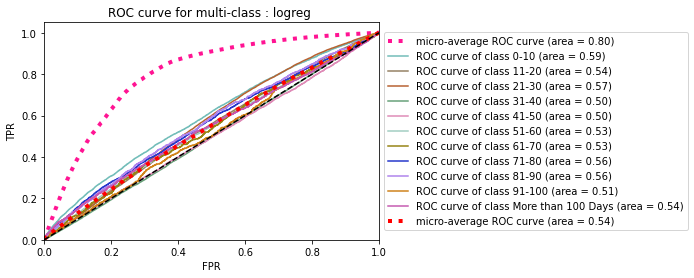

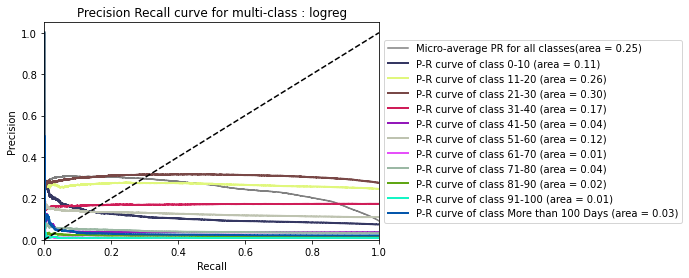

Building:  Decision Tree


C:\Users\14694\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


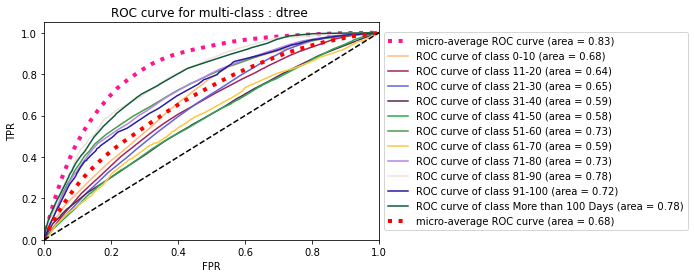

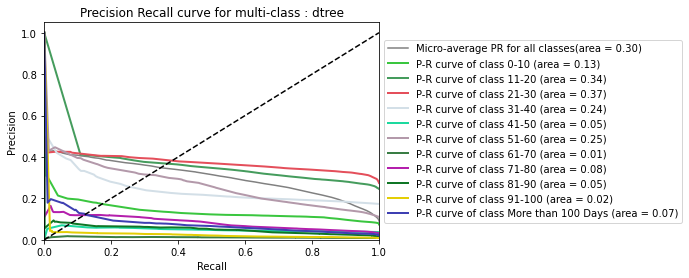

Building:  Random Forest


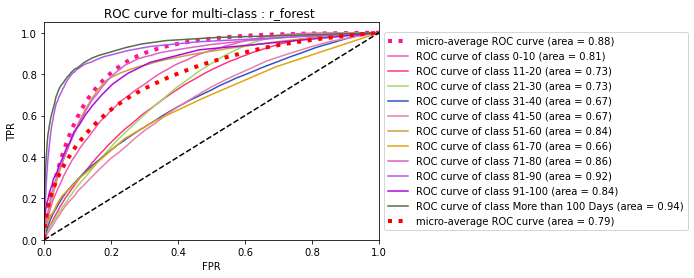

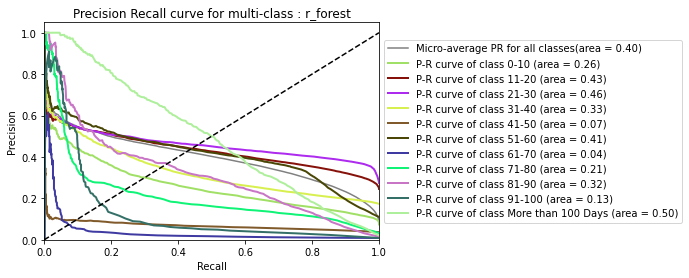

Building:  GBM


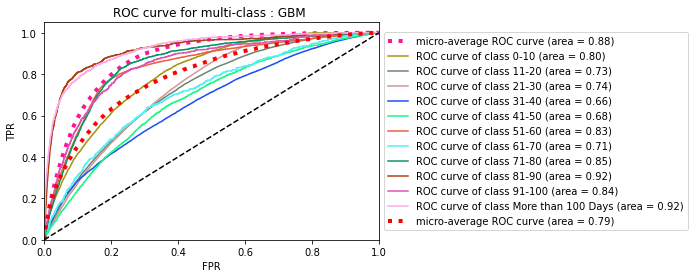

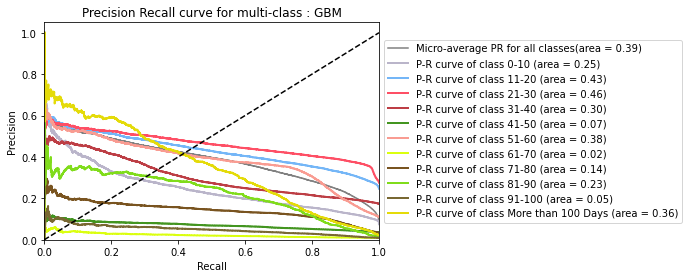

[{'Name': 'logreg', 'Classifier name': LogisticRegression(multi_class='multinomial', n_jobs=-1, random_state=88), 'Classifier': LogisticRegression(C=10, multi_class='multinomial', n_jobs=-1, random_state=88), 'Best parameters': {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}, 'ROC AUC score': 0.5361426290381563, 'Accuracy': 0.2790729807813089, 'Precision-Micro': 0.2790729807813089, 'Precision-Macro': 0.049332208067443206, 'Recall-Micro': 0.2790729807813089, 'Recall-Macro': 0.09454243717139826, 'F1-micro': 0.2790729807813089, 'F1-macro': 0.06029808335535496, 'ROC AUC(Valid) score': 0.5385793411205626, 'Cohen Kappa': 0.014574879440459543, 'Confusion matrix': array([[    0,  1840,  4061,     0,     0,     0,     0,     0,     0,
            0,     0],
       [    0,  4430, 15105,     0,     0,     0,     0,     0,     0,
            0,     0],
       [    0,  4086, 17787,     0,     0,     0,     0,     0,     0,
            0,     0],
       [    0,  2847, 10943,     0,     0,     0,     0

In [23]:
if __name__ =="__main__":
    results_df = pd.DataFrame()
    WOE_results = pd.DataFrame()
    proj_dir = "C:\\Users\\14694\\Documents\\Multiclass project"
    #project = ["Car_safety","Car_segmentation","Baseball","Eucalyptus","Hypothyroid"]
    project = ["healthcare"]
    info_save_result = "Multiclass-WOE.json"
    for i,proj in enumerate(project):
        try:
            proj_run_info = main(proj_dir,proj)
            #with open(proj_dir+"\\"+project+"\\"+info_save_result , 'w') as output:
                #json.dump(proj_run_info,output)
            print(proj_run_info)
            results_df = pd.DataFrame(proj_run_info)
            results_df.insert(0, 'Data', proj)
            results_df.insert(1,'Encoding','WOE')
            #results_df.to_csv(proj_dir+"\\"+proj+'\\ROC_Plottest.csv', index=False)
            #WOE_results = [WOE_results,results_df]
        except Exception as e:
            print(e)

In [24]:
proj_run_info

[{'Name': 'logreg',
  'Classifier name': LogisticRegression(multi_class='multinomial', n_jobs=-1, random_state=88),
  'Classifier': LogisticRegression(C=10, multi_class='multinomial', n_jobs=-1, random_state=88),
  'Best parameters': {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'},
  'ROC AUC score': 0.5361426290381563,
  'Accuracy': 0.2790729807813089,
  'Precision-Micro': 0.2790729807813089,
  'Precision-Macro': 0.049332208067443206,
  'Recall-Micro': 0.2790729807813089,
  'Recall-Macro': 0.09454243717139826,
  'F1-micro': 0.2790729807813089,
  'F1-macro': 0.06029808335535496,
  'ROC AUC(Valid) score': 0.5385793411205626,
  'Cohen Kappa': 0.014574879440459543,
  'Confusion matrix': array([[    0,  1840,  4061,     0,     0,     0,     0,     0,     0,
              0,     0],
         [    0,  4430, 15105,     0,     0,     0,     0,     0,     0,
              0,     0],
         [    0,  4086, 17787,     0,     0,     0,     0,     0,     0,
              0,     0],
         [    0, 

In [25]:
results_df = pd.DataFrame(proj_run_info)
results_df.insert(0, 'Data', proj)

#### Results of the data


In [26]:
results_df

,Data,Name,Classifier name,Classifier,Best parameters,ROC AUC score,Accuracy,Precision-Micro,Precision-Macro,Recall-Micro,Recall-Macro,F1-micro,F1-macro,ROC AUC(Valid) score,Cohen Kappa,Confusion matrix
0,healthcare,logreg,"LogisticRegression(multi_class='multinomial', ...","LogisticRegression(C=10, multi_class='multinom...","{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.536143,0.279073,0.279073,0.049332,0.279073,0.094542,0.279073,0.060298,0.538579,0.014575,"[[0, 1840, 4061, 0, 0, 0, 0, 0, 0, 0, 0], [0, ..."
1,healthcare,dtree,DecisionTreeClassifier(random_state=88),"DecisionTreeClassifier(max_depth=6, max_featur...","{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.681011,0.336201,0.336201,0.155191,0.336201,0.136373,0.336201,0.119646,0.679005,0.126565,"[[38, 2726, 2669, 160, 0, 308, 0, 0, 0, 0, 0],..."
2,healthcare,r_forest,"RandomForestClassifier(n_jobs=-1, random_state...","(DecisionTreeClassifier(max_features='auto', r...",{'n_estimators': 300},0.785283,0.417159,0.417159,0.435669,0.417159,0.256525,0.417159,0.271351,0.787847,0.253548,"[[912, 2770, 2080, 111, 8, 18, 0, 2, 0, 0, 0],..."
3,healthcare,GBM,GradientBoostingClassifier(random_state=88),([DecisionTreeRegressor(criterion='friedman_ms...,{'learning_rate': 0.1},0.789457,0.410690,0.410690,0.287302,0.410690,0.230414,0.410690,0.222468,0.789846,0.243083,"[[628, 2959, 2245, 50, 2, 14, 0, 1, 0, 2, 0], ..."


#### A comparsion between the various models tells us that Random Forest algorithm worked best to predict the patient length of stay with an accuracy of 41.7% and ROC score of 78.9%